In [1]:
%load_ext autoreload
%autoreload 2
from pangolin import *
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
np.set_printoptions(precision=2)

In [2]:
# based on models defined in https://mc-stan.org/docs/stan-users-guide/item-response-models.html

def simulate_inputs(J,K,N):
    jj = np.random.randint(0,J,(N,))
    kk = np.random.randint(0,K,(N,))
    return jj,kk

def viz_data(jj,kk,y_obs):
    correct = np.zeros((J,K))
    total = np.zeros((J,K))
    for n in range(N):
        correct[jj[n],kk[n]] += y_obs[n]
        total[jj[n],kk[n]] += 1
    # take mean, don't complain about nan
    with np.errstate(invalid='ignore'):
        mean_correct = correct / total
    plt.figure(figsize=(10,3.5))
    sns.heatmap(mean_correct,cmap="Spectral", vmin=0, vmax=1)
    plt.gca().patch.set(hatch='x', edgecolor='black')
    plt.xlabel('question')
    plt.ylabel('student')
    plt.title('mean correct (hatch: student never saw question)')
    #plt.colorbar();
    plt.show()
    
def visualize_posterior(alphas,alpha_true,betas,beta_true,gammas=None,gamma_true=None):
    J = len(alpha_true)
    K = len(beta_true)

    plt.figure(figsize=(10,2.5))
    sns.swarmplot(alphas[::20,:],s=2);
    plt.plot(np.arange(J),alpha_true,'k.',markersize=10,label='true alpha',zorder=5)
    plt.legend()
    plt.xlabel('student')
    plt.ylabel('alpha');
    plt.show()

    plt.figure(figsize=(10,2.5))
    sns.swarmplot(betas[::20,:],s=2);
    plt.plot(np.arange(K),beta_true,'k.',markersize=10,label='true beta',zorder=5)
    plt.legend()
    plt.xlabel('question')
    plt.ylabel('beta');  
    plt.show()
    
    if gammas is not None:
        plt.figure(figsize=(10,2.5))
        sns.swarmplot(gammas[::20,:],s=2,log_scale=True);
        plt.plot(np.arange(K),gamma_true,'k.',markersize=10,label='true gamma',zorder=5)
        plt.legend()
        plt.xlabel('question')
        plt.ylabel('gamma');  


def do_experiment_1PL(J,K,N):
    # J - num students
    # K - num questions
    # N - num observations
    
    jj,kk = simulate_inputs(J,K,N)
    
    # define model
    alpha = plate(N=J)(lambda:
                       normal(0,1))
    beta = plate(N=K)(lambda:
                      normal(0,1))
    delta = normal(0.75,1)
    logits = alpha[jj] - beta[kk] + delta # vectorized - and +
    y = vmap(bernoulli_logit)(logits)
    
    # simulate latents and outputs
    calc = Calculate("numpyro",niter=1)
    [alpha_true], [beta_true], [delta_true], [y_obs] = calc.sample([alpha, beta, delta, y])
    
    viz_data(jj,kk,y_obs)
    
    # do inference
    calc = Calculate("numpyro",niter=1000)
    [alphas, betas] = calc.sample([alpha,beta],y,y_obs)
    
    # visualize posterior
    visualize_posterior(alphas,alpha_true,betas,beta_true)

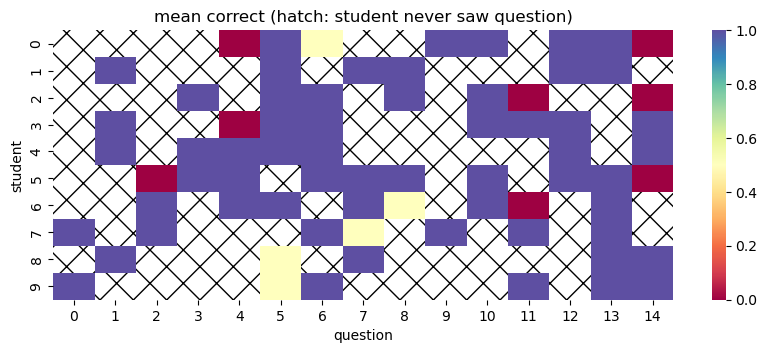

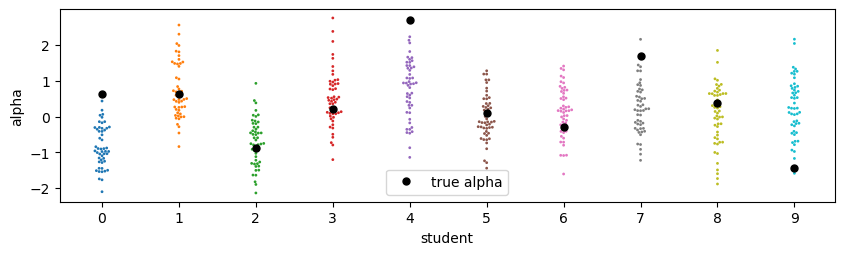

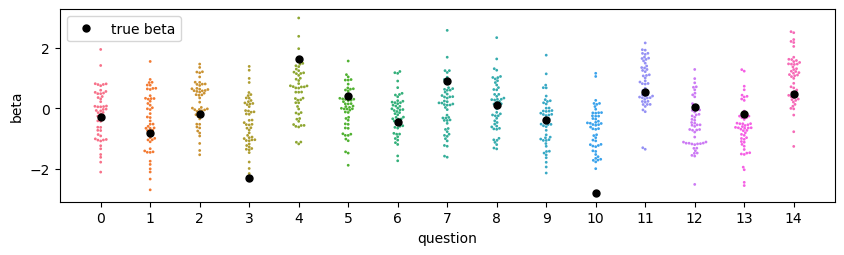

In [3]:
# experiment with sparse observations

J = 10 # num students
K = 15 # num questions
N = 100 # num observations
do_experiment_1PL(J,K,N)

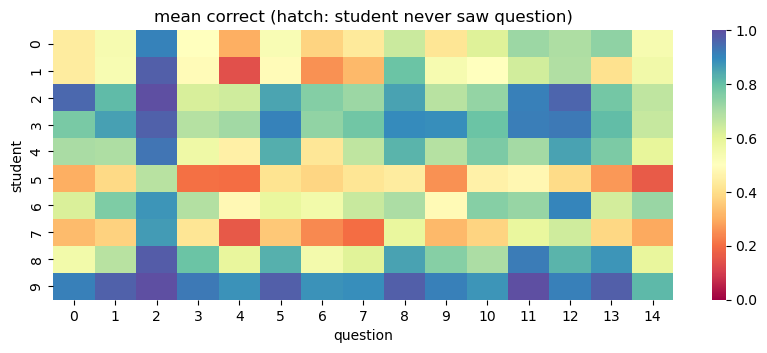

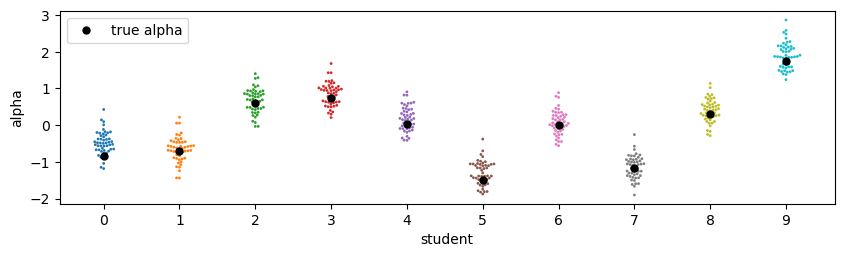

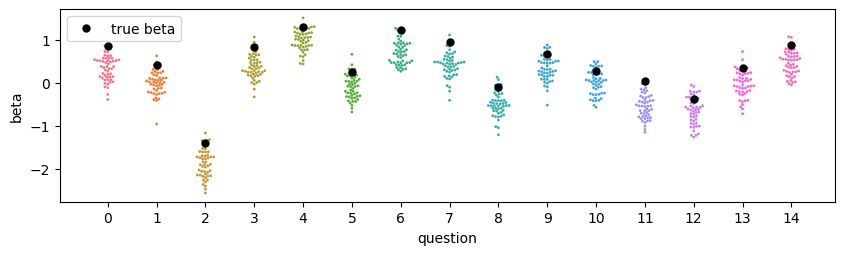

In [4]:
# experiment with MANY observations
# notice how certain questions are clearly harder than others
# and certain students are clearly stronger than others and this shows up in
# the posterior

J = 10 # num students
K = 15 # num questions
N = 5000 # num observations
do_experiment_1PL(J,K,N)

In [7]:
# now define fancier model

def do_experiment_2PL(J,K,N):
    jj,kk = simulate_inputs(J,K,N)
    
    # define model
    alpha = plate(N=J)(lambda:
                       normal(0,1))
    sigma_beta = abs(normal(0,5)) # TODO: cauchy
    mu_beta = normal(0,5)
    beta_uncentered = plate(N=K)(lambda:
                      normal(0,sigma_beta))
    beta = beta_uncentered + mu_beta
    gamma = plate(N=K)(lambda:
                       exp(normal(0,2)))
    delta = normal(0.75,1)
    logits = gamma[kk] * (alpha[jj] - beta[kk] + delta)
    y = vmap(bernoulli_logit)(logits)
    
    # simulate latents and outputs
    calc = Calculate("numpyro",niter=1)
    [alpha_true], [beta_true], [delta_true], [gamma_true], [y_obs] = calc.sample([alpha, beta, delta, gamma, y])
    
    viz_data(jj,kk,y_obs)
    
    # do inference
    calc = Calculate("numpyro",niter=1000)
    [alphas, betas, gammas] = calc.sample([alpha,beta,gamma],y,y_obs)
    
    # visualize posterior
    visualize_posterior(alphas,alpha_true,betas,beta_true,gammas,gamma_true)

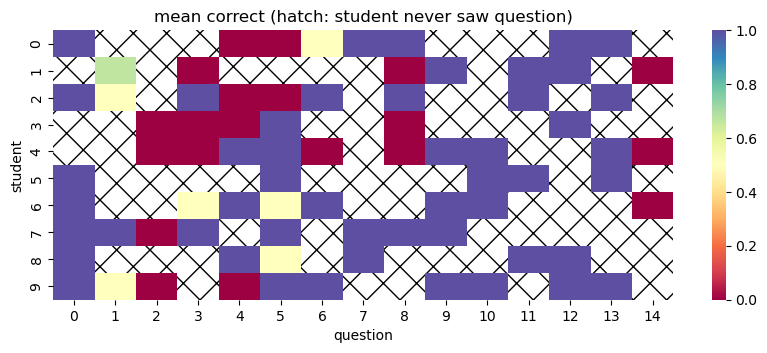

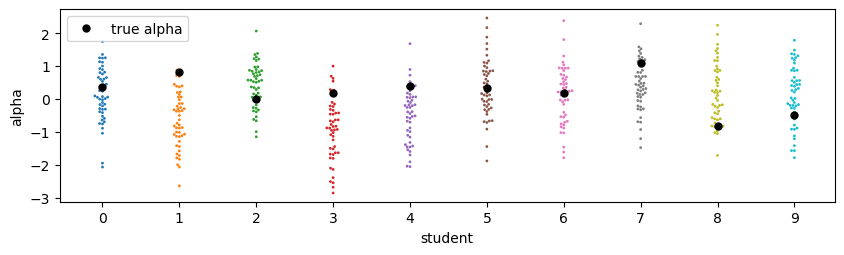

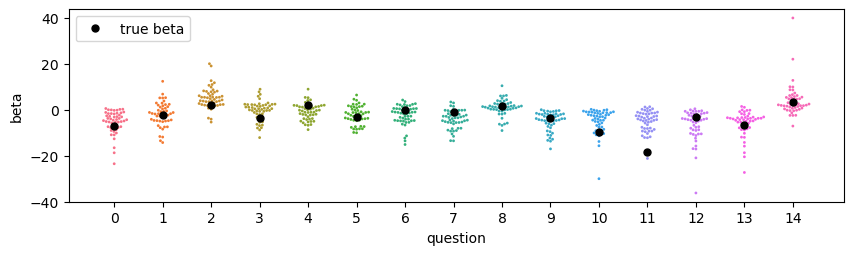

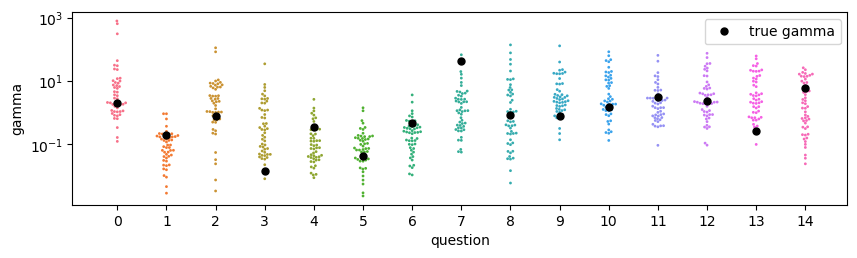

In [8]:
J = 10 # num students
K = 15 # num questions
N = 100 # num observations
do_experiment_2PL(J,K,N)

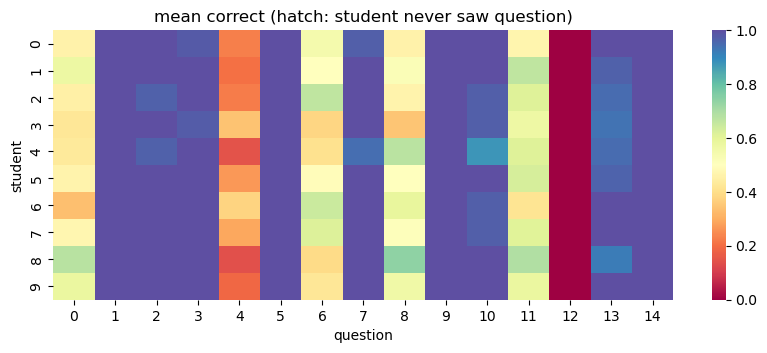

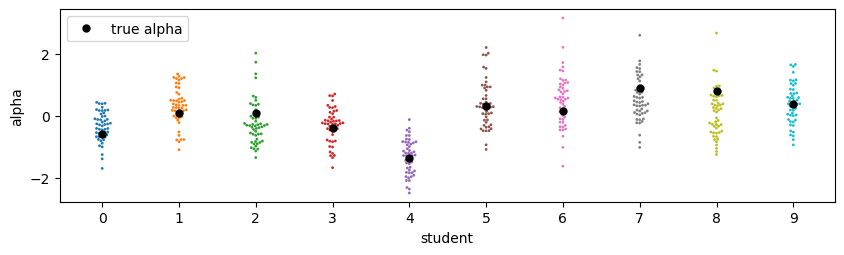

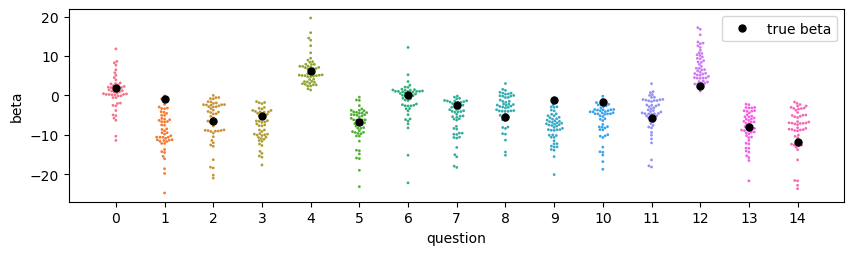

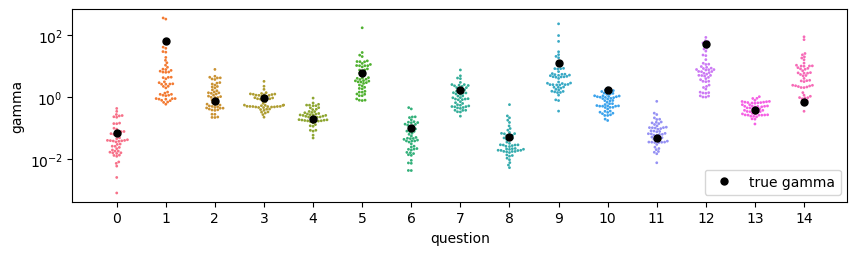

In [10]:
J = 10 # num students
K = 15 # num questions
N = 5000 # num observations
do_experiment_2PL(J,K,N)